In [1]:
import pandas as pd

from datetime import datetime

import seaborn as sns
sns.set()

В следующем абзаце парсится rfm.tsv. В нём содержатся символы, которые ломают парсер utf-8, поэтому пришлось подкостылить кодировку. По той же причине не работает нормально read_table. Эти символы зашиты куда-то в категории в строчках, которые не click, так что для этого анализа они не оч интересны.

Хэдера тоже нет, добавил руками. Если что, порядок добавления элементов в словарь сохраняется с 3.7, так что rfm_dtypes.keys() возвращает ключи в указанном порядке.

Обнуление data_list в конце -- кивок в сторону garbage collector, чтобы лишние сотни мб не висели в оперативке.

In [2]:
rfm_dtypes = {
    'timestamp': int,
    'user_id': str,
    'url': str,
    'geo_id': int,
    'category': int,
    'price': int
}

data_list = []
with open('rfm.tsv', encoding='cp1251') as rfm_file:
    for line in rfm_file:
        values = line.strip('\n').split('\t')
        line_data = dict(zip(rfm_dtypes.keys(), values))
        if line_data['url'] != 'click':
            continue
        del line_data['url']
        line_data = {key: rfm_dtypes[key](value) for key, value in line_data.items()}
        data_list.append(line_data)

df = pd.DataFrame(data_list)
data_list = None

In [3]:
geo = pd.read_table('geo_table.tsv')
categories = pd.read_table('categories_tree.tsv')

In [4]:
df.tail()

,timestamp,user_id,geo_id,category,price
363308,1363707700,ffffd6bd3a3f1e7b3b92a790104a6ae4,35,91011,31
363309,1363707492,ffffd6bd3a3f1e7b3b92a790104a6ae4,35,91011,37
363310,1363708054,ffffd6bd3a3f1e7b3b92a790104a6ae4,35,91011,37
363311,1363707459,ffffd6bd3a3f1e7b3b92a790104a6ae4,35,91011,45
363312,1360163592,ffffda42ccd5f1ed15a700b23fc6c8e5,39,91491,16


In [5]:
geo.tail()

,id,name,parent_region_id,type,TZ_OFFSET
51661,127495,Котельников,99244.0,7,10800
51662,127496,Красноярский,99244.0,7,10800
51663,127497,Майоровский,99244.0,7,10800
51664,127498,Нагавская,99244.0,7,10800
51665,127499,Нагольный,99244.0,7,10800


In [6]:
categories.tail()

,id,parent_id,hyper_cat_id,category_name,category_pass
1930,26387,23650,13061828,Клей,\tВсе для офиса\tРасходные материалы\tКлей\t
1931,84,23650,91046,Бумага и пленка,\tВсе для офиса\tРасходные материалы\tБумага и...
1932,18585,23650,6268029,Расходные материалы для брошюровщиков,\tВсе для офиса\tРасходные материалы\tРасходны...
1933,509,23650,90741,Скотч,\tВсе для офиса\tРасходные материалы\tСкотч\t
1934,510,23650,90742,"Скрепки, кнопки","\tВсе для офиса\tРасходные материалы\tСкрепки,..."


In [7]:
df['dttm'] = df.timestamp.apply(lambda x: pd.Timestamp(x, unit='s'))

In [8]:
min(df.dttm), max(df.dttm)

(Timestamp('2012-12-31 20:09:40'), Timestamp('2013-12-31 19:56:08'))

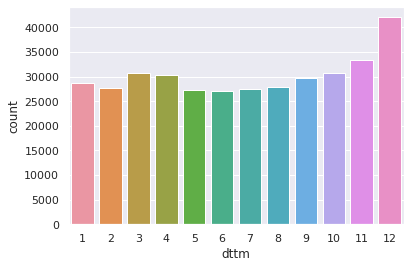

In [9]:
sns.countplot(df.dttm.dt.month)

In [10]:
df_sample = df[(datetime(year=2013, month=7, day=1) > df.dttm) & (df.dttm > datetime(year=2013, month=6, day=1))]

In [11]:
df_sample

,timestamp,user_id,geo_id,category,price,dttm
102,1370680372,001725c32b8fd7289df6052edf999bd6,213,91491,64,2013-06-08 08:32:52
270,1370422908,0040041568f64b9b40baca2e81757e52,21,90401,10,2013-06-05 09:01:48
271,1370422818,0040041568f64b9b40baca2e81757e52,21,90401,26,2013-06-05 09:00:18
272,1370422985,0040041568f64b9b40baca2e81757e52,21,91167,10,2013-06-05 09:03:05
353,1371563843,0053453af8bd4491799b8384aba1435f,2,91491,46,2013-06-18 13:57:23
...,...,...,...,...,...,...
363108,1370179058,ffe49f815ad28a9d2de9ab97cb2fc6df,194,6269371,12,2013-06-02 13:17:38
363109,1370895369,ffe49f815ad28a9d2de9ab97cb2fc6df,194,6269371,14,2013-06-10 20:16:09
363204,1371364895,ffef09518dc1c41a9142c7d1af3b0717,11184,6101499,10,2013-06-16 06:41:35
363224,1371209680,fff21f91e25306f8ce63eb8f374dbf43,10951,7811901,270,2013-06-14 11:34:40


In [21]:
def rfm_quantiles(data, parts=4, dttm_name='dttm', price_name='price', user_name='user_id'):
    qs = [x / parts for x in range(parts)] + [1]
    monetary = df[[user_name, price_name]].groupby(user_name, as_index=False).median()
    monetary_edges = monetary[price_name].quantile(qs).tolist()
    print(monetary_edges)

In [22]:
rfm_quantiles(df)

[0.0, 10.0, 11.0, 25.0, 1000.0]
